In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep
from scipy.signal import correlate
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from scipy.stats import binned_statistic
from scipy.signal import correlation_lags

In [2]:
genotype = 'R60D05>sytGCaMP7f'
celltype = 'EPG-syt7f-EB'
trial_condition = 'cl'

In [3]:
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,run_ANOVA_for_comparing_across_genotypes
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude_V3, calcualteBumpAmplitude_V4,calculateBumpWidth_v1

In [60]:
pooled_directory = ('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/EPG_imaging_delta7_perturbation/vGlut RNAi/R27F02_lexop7b_R55G08_attp40/cl')
count = 0
output_crossc_pooled = []
lagged_Bump_amplitude_z_smooth_pooled = []
lagged_PVA_strength_pooled = []
lagged_Bump_width_pooled =[]
average_Bump_shape_pooled = pd.DataFrame()
Angular_speed_pooled = []
mean_PVA_strength_per_trial_pooled = []
for single_df in os.listdir(pooled_directory):
    if 'TQfly393' in single_df:
        current_file = pd.read_csv(sep.join([pooled_directory, single_df]))
        #Get time info
        volume_cycle = len(current_file )
        volume_time = current_file['Time_Stamp'][1]
        volume_rate = 1/volume_time
        time_array_imaging = np.arange(volume_cycle)/volume_rate
        #Get necessary parameters
        PVA_Unwrapped_Radian = current_file['Unwrapped_Radian'].values
        PVA_Angle = current_file['PVA_Angle'].values
        PVA_Radian = current_file['PVA_Radian'].values
        Angular_velocity = current_file['Angular_Velocity'].values
        PVA_strength = current_file['PVA_strength'].values
        Bump_amplitude = current_file['Bump_amplitude'].values
        Unwrapped_heading = current_file['Unwrapped_Bar_Position/Heading'].values
    
        dff_normalized_8_roi = np.array([current_file[f'dFF_Roi_{i}'] for i in range(1, 9)]).T
        dff_normalized_8_roi_shifted = np.zeros((len(current_file['dFF_Roi_1']), 8))
        for i in range(len(current_file['F_Roi_1'])):
            dff_normalized_8_roi_shifted[i,0]= current_file['dFF_Roi_5'][i]
            dff_normalized_8_roi_shifted[i,1]= current_file['dFF_Roi_6'][i]
            dff_normalized_8_roi_shifted[i,2]= current_file['dFF_Roi_7'][i]
            dff_normalized_8_roi_shifted[i,3]= current_file['dFF_Roi_8'][i]
            dff_normalized_8_roi_shifted[i,4]= current_file['dFF_Roi_1'][i]
            dff_normalized_8_roi_shifted[i,5]= current_file['dFF_Roi_2'][i]
            dff_normalized_8_roi_shifted[i,6]= current_file['dFF_Roi_3'][i]
            dff_normalized_8_roi_shifted[i,7]= current_file['dFF_Roi_4'][i]
        dff_normalized_8_roi_shifted = dff_normalized_8_roi_shifted.transpose()
        
        
        
        #Average bump shape peak centered
        df_dff_in_ROI_normalized_shifted_peak_centered = np.zeros((len(dff_normalized_8_roi_shifted),       len(dff_normalized_8_roi_shifted[0])))
        shifted_by_all = []
        for i in range(len(dff_normalized_8_roi_shifted[0])):
            original_order = [0,1,2,3,4,5,6,7]
            current_peak = np.argmax(dff_normalized_8_roi_shifted[:,i])
            shift_by = current_peak - 3
            shifted_order = original_order[shift_by % len(original_order):] + original_order[:shift_by % len(original_order)]
            df_dff_in_ROI_normalized_shifted_peak_centered[:,i] = dff_normalized_8_roi_shifted[shifted_order,i]
            shifted_by_all.append(shift_by)
    
        average_bump_shape = np.mean(df_dff_in_ROI_normalized_shifted_peak_centered, axis=1)
        average_bump_shape =pd.DataFrame(average_bump_shape)
 

        
        
        Angular_speed_degrees =  np.abs(Angular_velocity) * 180/np.pi
        
        #Average PVA_strength per trial
        mean_PVA_strength_per_trial_pooled.append(np.mean(PVA_strength))
        
        #Get persistence period
        persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = Angular_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))
    
        #Calculate and plot difference throughout the stop period
        difference_during_stop = []
        current_difference_during_stop = []
        #plt.figure(figsize= (25,7))
        for current_index in range(len(persistence_stop_index_and_length)):
            current_stop_PVA = PVA_Angle[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
            current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
            current_difference_during_stop = PVA_Angle[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
            #Modify the value so angle difference will never be different more than 180 degrees
            for j in range(len(current_difference_during_stop)):
                if np.abs(current_difference_during_stop[j]) > 180:
                    if current_difference_during_stop[j] < 0:
                        current_difference_during_stop[j] =  current_difference_during_stop[j] + 360
                    else:
                        current_difference_during_stop[j] =  current_difference_during_stop[j] - 360
            difference_during_stop.append(current_difference_during_stop)
    
        # calculate bump amplitude by getting the normalized dff at current PVA angle 
        Bump_amplitude_V3, Bump_amplitude_V3_opposite = calcualteBumpAmplitude_V3(dff_normalized_8_roi,PVA_Radian)
        Bump_amplitude_V4 =  calcualteBumpAmplitude_V4(Bump_amplitude_V3,dff_normalized_8_roi,PVA_Radian,persistence_stop_index_and_length)
    
        Bump_amplitude_smooth_for_speed_cor_V3 = gaussian_filter1d(Bump_amplitude_V3, sigma =5)
        Bump_amplitude_smooth_for_speed_cor_V4 = gaussian_filter1d(Bump_amplitude_V4, sigma =5)
        Bump_amplitude_z_smooth_for_speed_cor_V3 = zscore(Bump_amplitude_smooth_for_speed_cor_V3)
        Bump_amplitude_z_smooth_for_speed_cor_V4 = zscore(Bump_amplitude_smooth_for_speed_cor_V4)
        
        #Calculate bump width
        Bump_width_current = calculateBumpWidth_v1(dff_normalized_8_roi,8)
       
    
   
        # Calculate cross-correlation within the allowed lags range
        cross_corr = correlate(Angular_speed_degrees, Bump_amplitude_z_smooth_for_speed_cor_V3, mode='full')
        lags = correlation_lags(Angular_speed_degrees.size,  Bump_amplitude_z_smooth_for_speed_cor_V3.size, mode="full")
                                  
        #find the middle index to consider the frame on both side till max shift frame (1s)
        #max_shift_frame = int(volume_rate)
        #middle_index = int(len(lags)/2)
        #lags_short = lags[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
        #correlation_short = cross_corr[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
        #lag = lags_short[np.argmax(correlation_short)]
        #if lag > 0:
            #lag = lags_short[np.argmax(correlation_short[0:int((len(correlation_short)-1)/2+1)])]
        lag = int(-0.3/volume_time)
        output_crossc_pooled.append(lag*volume_time)
     
        # Apply the lag only to Bump_amplitude_z_smooth_for_speed_cor
    
        #shift back tne bump_amplitude or PVA strength by drop the lag frame at the beginning
        lagged_Bump_amplitude_z_smooth_for_speed_cor = Bump_amplitude_z_smooth_for_speed_cor_V3[-lag:]
        Angular_speed_degrees = Angular_speed_degrees[:len(lagged_Bump_amplitude_z_smooth_for_speed_cor)]
        lagged_PVA_strength_for_speed_cor = PVA_strength[-lag:]
        lagged_Bump_width_for_spped_cor = Bump_width_current[-lag:]
    
        if count == 0:
            lagged_Bump_amplitude_z_smooth_pooled = lagged_Bump_amplitude_z_smooth_for_speed_cor
            Angular_speed_pooled  = Angular_speed_degrees
            lagged_PVA_strength_pooled = lagged_PVA_strength_for_speed_cor
            lagged_Bump_width_pooled = lagged_Bump_width_for_spped_cor
            average_Bump_shape_pooled = average_bump_shape
        else:
            lagged_Bump_amplitude_z_smooth_pooled = np.concatenate((lagged_Bump_amplitude_z_smooth_pooled ,lagged_Bump_amplitude_z_smooth_for_speed_cor))
            Angular_speed_pooled  = np.concatenate((Angular_speed_pooled,Angular_speed_degrees)) 
            lagged_PVA_strength_pooled = np.concatenate((lagged_PVA_strength_pooled ,lagged_PVA_strength_for_speed_cor))
            lagged_Bump_width_pooled =  np.concatenate((lagged_Bump_width_pooled ,lagged_Bump_width_for_spped_cor))
            average_Bump_shape_pooled = pd.concat([average_Bump_shape_pooled ,average_bump_shape],ignore_index=True, axis =1) 
        count = count + 1

In [61]:
np.mean(average_Bump_shape_pooled,axis=1) 

0    0.237733
1    0.448574
2    0.732639
3    0.900038
4    0.722196
5    0.442915
6    0.228258
7    0.169048
dtype: float64

In [30]:
mean_PVA_strength_per_trial_pooled

[0.7447273785743376, 0.8329657006374234, 0.7019886958344753]

In [31]:
np.mean(mean_PVA_strength_per_trial_pooled)

0.7598939250154121

In [7]:
pooled_PVA_strength_delta7_shi_df= pd.read_csv('/home/tianhaoqiu/Desktop/Analysis/delta7_syt6s_EPG_shi_mean_PVA_strength_per_fly.csv')

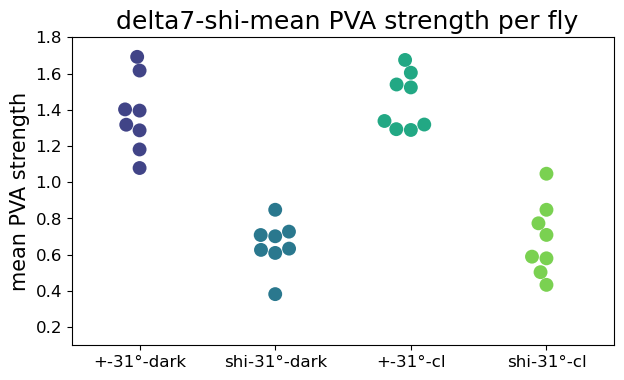

In [8]:
columns_to_plot_PVA_strength = ['+-31°-dark', 'shi-31°-dark','+-31°-cl','shi-31°-cl']


# Create a swarm plot
plt.figure(figsize=(7, 4))
sns.swarmplot(data=pooled_PVA_strength_delta7_shi_df[columns_to_plot_PVA_strength], palette='viridis', size=10)

# Connect corresponding dots with lines
#for i in range(len(pooled_PVA_strength_delta7_shi_df)):
    #plt.plot([0, 1, 2, 3], pooled_PVA_strength_delta7_shi_df.loc[i, columns_to_plot_PVA_strength].values, color='gray', alpha=0.3)


plt.title(' delta7-shi-mean PVA strength per fly', fontsize = 18)
plt.ylabel('mean PVA strength',fontsize =15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.1,1.8)
plt.show()

In [9]:
run_ANOVA_for_comparing_across_genotypes(pooled_PVA_strength_delta7_shi_df,columns_to_plot_PVA_strength)

One-way ANOVA Result:
F-statistic: 47.06271203857653
p-value: 4.60759450272419e-11
Adjusted df between: 3
Adjusted df within: 28
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1      group2    meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
  +-31°-cl   +-31°-dark  -0.0764 0.8226 -0.3173  0.1646  False
  +-31°-cl   shi-31°-cl   -0.762    0.0  -1.003 -0.5211   True
  +-31°-cl shi-31°-dark  -0.7928    0.0 -1.0337 -0.5518   True
+-31°-dark   shi-31°-cl  -0.6857    0.0 -0.9266 -0.4447   True
+-31°-dark shi-31°-dark  -0.7164    0.0 -0.9574 -0.4754   True
shi-31°-cl shi-31°-dark  -0.0307 0.9852 -0.2717  0.2102  False
--------------------------------------------------------------


In [10]:
output_crossc_pooled

[-0.2565, -0.2565]

In [42]:
Angular_speed_pooled.shape

(2930,)

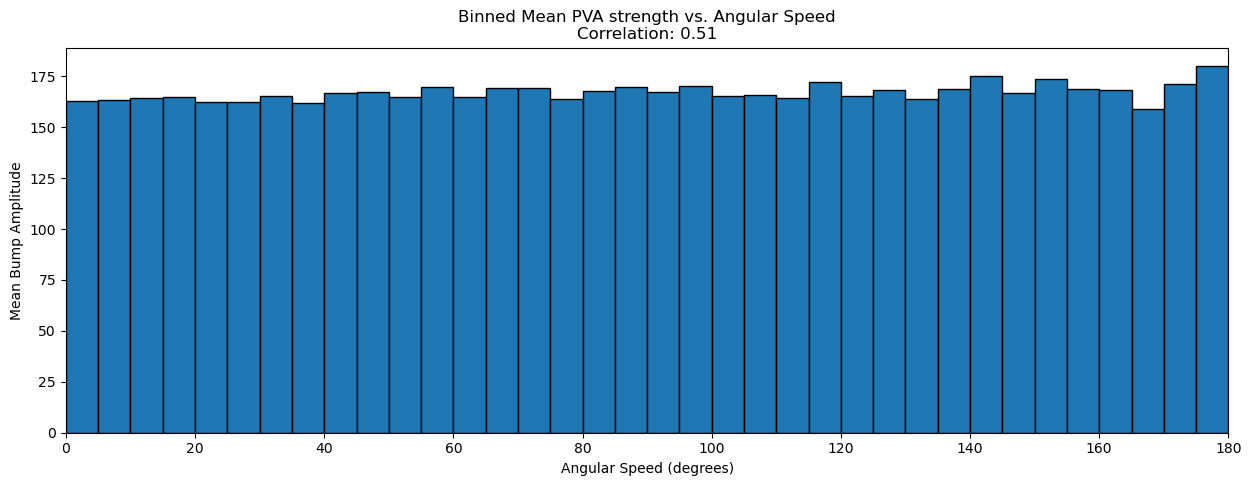

In [62]:
# Define the bin edges with a bin width of 5/1
bin_width = 5
bin_edges = np.arange(0, 180 + bin_width, bin_width)

# Use scipy's binned_statistic to calculate the mean bump amplitude for each bin
binned_stats = binned_statistic(Angular_speed_pooled,  lagged_Bump_width_pooled, statistic='mean', bins=bin_edges)

# Extract the mean bump amplitude and bin centers
mean_Bump_width_per_bin = binned_stats.statistic
#mean_PVA_strength_per_bin = binned_stats.statistic
bin_centers = binned_stats.bin_edges[:-1] + 0.5 * bin_width

# Exclude bins with no data points
#valid_bins = ~np.isnan(mean_PVA_strength_per_bin)
valid_bins = ~np.isnan(mean_Bump_width_per_bin)

# Calculate the correlation between mean bump amplitude and bin centers for valid bins
correlation_coefficient = np.corrcoef(bin_centers[valid_bins], mean_Bump_width_per_bin[valid_bins])[0, 1]

# Plot the binned mean bump amplitude against the angular speed for valid bins
plt.figure(figsize=(15, 5))
plt.bar(bin_centers[valid_bins], mean_Bump_width_per_bin[valid_bins], width=bin_width, align='center', edgecolor='black')
plt.xlim(0, np.max(bin_edges))  # Set the limit for angular speed
plt.xlabel('Angular Speed (degrees)')
plt.ylabel('Mean Bump Amplitude')
plt.title(f'Binned Mean PVA strength vs. Angular Speed\nCorrelation: {correlation_coefficient:.2f}')
plt.show()

In [63]:
# Print the number of values in each bin
bin_numbers = binned_stats.binnumber
# Print the number of values in each bin
for i in range(1, len(np.unique(bin_numbers)) +1 ):
    count = np.sum(bin_numbers == i)
    print(f'Bin {i}: {count} values')

Bin 1: 2469 values
Bin 2: 951 values
Bin 3: 802 values
Bin 4: 578 values
Bin 5: 529 values
Bin 6: 454 values
Bin 7: 392 values
Bin 8: 340 values
Bin 9: 311 values
Bin 10: 253 values
Bin 11: 228 values
Bin 12: 223 values
Bin 13: 203 values
Bin 14: 198 values
Bin 15: 179 values
Bin 16: 165 values
Bin 17: 155 values
Bin 18: 138 values
Bin 19: 149 values
Bin 20: 108 values
Bin 21: 91 values
Bin 22: 80 values
Bin 23: 95 values
Bin 24: 92 values
Bin 25: 77 values
Bin 26: 65 values
Bin 27: 62 values
Bin 28: 59 values
Bin 29: 67 values
Bin 30: 48 values
Bin 31: 55 values
Bin 32: 32 values
Bin 33: 43 values
Bin 34: 36 values
Bin 35: 31 values
Bin 36: 22 values
Bin 37: 210 values


In [64]:
mean_Bump_width_per_bin

array([162.99513973, 163.39116719, 164.28927681, 164.97404844,
       162.30623819, 162.45594714, 165.30612245, 162.        ,
       166.68810289, 167.19367589, 165.        , 169.50672646,
       164.92610837, 169.09090909, 169.18994413, 163.90909091,
       167.51612903, 169.89130435, 167.31543624, 170.41666667,
       165.16483516, 165.9375    , 164.36842105, 172.17391304,
       165.38961039, 168.23076923, 164.03225806, 168.55932203,
       175.29850746, 166.875     , 173.45454545, 168.75      ,
       168.48837209, 158.75      , 171.29032258, 180.        ])

In [65]:
# Convert the list to a DataFrame
df = pd.DataFrame({'Column Name': mean_Bump_width_per_bin})
# Save the DataFrame to a CSV file
df.to_csv('/home/tianhaoqiu/Desktop/Bump_width.csv', encoding='utf-8', index=False)

In [66]:
pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df= pd.read_csv('/home/tianhaoqiu/Desktop/EPG_7b_delta7_vglut/Bump_width_EPG_7B_delta7_attp40_cl.csv')
pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df= pd.read_csv('/home/tianhaoqiu/Desktop/EPG_7b_delta7_vglut/Bump_width_EPG_7B_delta7_vglut_cl.csv')

In [67]:
pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.columns = range(len(pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.columns))
pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.columns = range(len(pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.columns))

In [68]:
angular_speed_array = np.arange(0, 180, 5)
#angular_speed_array = np.arange(0, 20, 1)

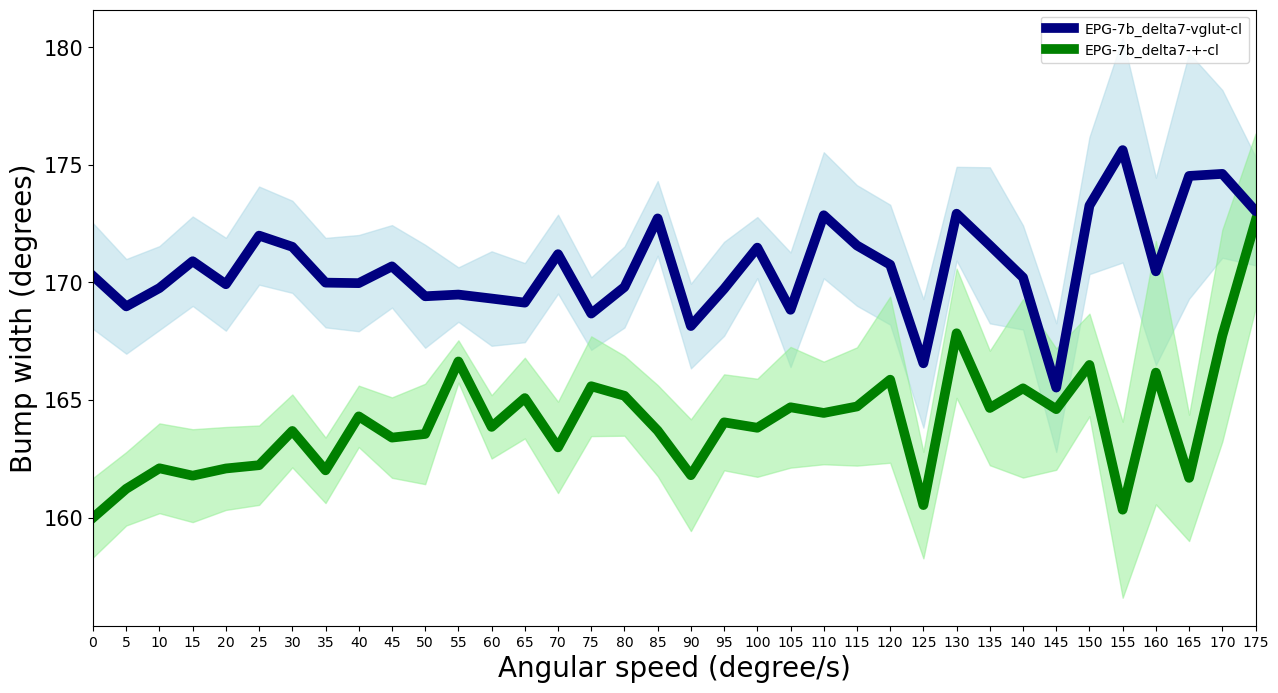

In [69]:
# Calculate mean and SEM for the first DataFrame (blue)
mean_delta7 = pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.mean(axis=1)
sem_delta7 = pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.sem(axis=1)

# Calculate mean and SEM for the second DataFrame (green)
mean_EPG = pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.mean(axis=1)
sem_EPG = pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.sem(axis=1)

# Plot mean and SEM for the first DataFrame (blue)
plt.figure(figsize=(15, 8))
plt.plot(mean_delta7, linewidth=7, color='navy', label='EPG-7b_delta7-vglut-cl')
plt.fill_between(mean_delta7.index, mean_delta7 - sem_delta7, mean_delta7 + sem_delta7, color='lightblue', alpha=0.5)

# Plot mean and SEM for the second DataFrame (green)
plt.plot(mean_EPG, linewidth=7, color='green', label='EPG-7b_delta7-+-cl')
plt.fill_between(mean_EPG.index, mean_EPG - sem_EPG, mean_EPG + sem_EPG, color='lightgreen', alpha=0.5)


plt.xticks(mean_delta7.index,angular_speed_array,size = 10)
plt.yticks(size = 15)
plt.xlim(0,35)

# Set labels and title
plt.xlabel('Angular speed (degree/s)', size = 20)
#plt.ylabel('Bump amplitude (z-scored)', size = 20)
#plt.ylabel('PVA strength', size = 20)
plt.ylabel('Bump width (degrees)', size = 20)
#plt.title('Mean Bump Amplitude with SEM')
plt.legend()
plt.show()

In [560]:
delta7_correlation_coefficient = np.zeros(len(pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.columns))
EPG_correlation_coefficient = np.zeros(len(pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.columns))

In [561]:
for i in range(len(pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.columns)):
    delta7_correlation_coefficient[i] = np.corrcoef(angular_speed_array,pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df[i])[0, 1]
for i in range(len(pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.columns)):
    EPG_correlation_coefficient[i] = np.corrcoef(angular_speed_array,pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df[i])[0, 1]

In [562]:
 delta7_correlation_coefficient

array([ 0.39366772,  0.4415502 , -0.39861671,  0.29797161, -0.14943363,
        0.71761686, -0.47033316])

In [563]:
EPG_correlation_coefficient

array([0.61138789, 0.75444518, 0.66353601, 0.52161884, 0.47499343,
       0.89838546, 0.83027171, 0.50419251])

/tmp/ipykernel_439387/1405352974.py:10: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='Group', y='Value', data=df, palette='viridis', size=10)


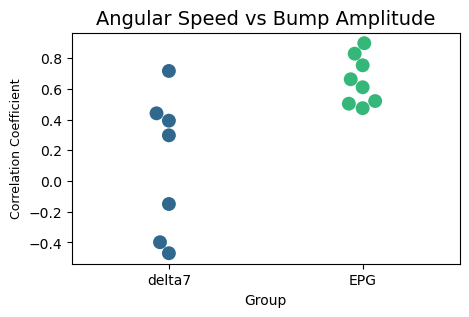

In [564]:

# Combine arrays and create a corresponding group array for swarmplot
data = np.concatenate([ delta7_correlation_coefficient, EPG_correlation_coefficient])
group = np.concatenate([['delta7'] * len(delta7_correlation_coefficient), ['EPG'] * len(EPG_correlation_coefficient)])

# Create a DataFrame for seaborn
df = pd.DataFrame({'Value': data, 'Group': group})

# Create swarmplot
plt.figure(figsize=(5, 3))
sns.swarmplot(x='Group', y='Value', data=df, palette='viridis', size=10)

# Set labels and title
plt.ylabel('Correlation Coefficient',size =9)
plt.title('Angular Speed vs Bump Amplitude',size = 14)
plt.show()


In [ ]:
pooled_PVA_strength_VS_AV_delta7_PB_syt_df.columns = range(len(pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.columns))
pooled_PVA_strength_VS_AV_EPG_PB_syt_df.columns = range(len(pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.columns))

In [ ]:
# Calculate mean and SEM for the first DataFrame (blue)
mean_delta7_cl_con = pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.mean(axis=1)
sem_delta7 = pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.sem(axis=1)

# Calculate mean and SEM for the second DataFrame (green)
mean_EPG = pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.mean(axis=1)
sem_EPG = pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.sem(axis=1)

# Plot mean and SEM for the first DataFrame (blue)
plt.figure(figsize=(15, 8))
plt.plot(mean_delta7, linewidth=7, color='navy', label='Delta7')
plt.fill_between(mean_delta7.index, mean_delta7 - sem_delta7, mean_delta7 + sem_delta7, color='lightblue', alpha=0.5)

# Plot mean and SEM for the second DataFrame (green)
plt.plot(mean_EPG, linewidth=7, color='green', label='EPG')
plt.fill_between(mean_EPG.index, mean_EPG - sem_EPG, mean_EPG + sem_EPG, color='lightgreen', alpha=0.5)


plt.xticks(mean_delta7.index,angular_speed_array,size = 15)
plt.yticks(size = 15)
plt.xlim(0,19)

# Set labels and title
plt.xlabel('Angular speed (degree/s)', size = 20)
plt.ylabel('Bump amplitude (z-scored)', size = 20)
#plt.title('Mean Bump Amplitude with SEM')
plt.legend()
plt.show()